In [194]:
import numpy as np
import pandas as pd
from importlib import reload
import heston
import matplotlib.pyplot as plt
import levenberg_marquardt
reload(levenberg_marquardt)
reload(heston)
from matplotlib.pyplot import figure

from heston import fHes, JacHes, MarketParameters, ModelParameters
from levenberg_marquardt import Levenberg_Marquardt
from typing import Tuple
import datetime
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

In [149]:
df = pd.read_csv(f"../datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")
df = df.drop(columns = ["exchange", "open_interest", 
                    "last_price", "bid_price", "bid_amount", "bid_iv",
                           "ask_price", "ask_amount", "ask_iv", "underlying_index",
                           "delta", "gamma", "vega", "theta" ,"rho"])
currency = "ETH"
ind = [symbol.startswith(currency) for symbol in df.symbol]
df = df[ind].reset_index(drop=True)

In [175]:
df.head()

,symbol,timestamp,local_timestamp,type,strike_price,expiration,mark_price,mark_iv,underlying_price,tau,payoff,inverse_payoff
0,ETH-9DEC22-1400-C,1669852800002000,1669852800011631,call,1400,1670572800000000,0.0146,69.75,1294.5900,0.022831,0.0000,0.000000
1,ETH-16DEC22-1300-P,1669852800011000,1669852800014218,put,1300,1671177600000000,0.0632,74.51,1294.5233,0.042009,5.4767,0.004231
2,ETH-16DEC22-1500-C,1669852800010000,1669852800017777,call,1500,1671177600000000,0.0140,73.44,1294.5233,0.042009,0.0000,0.000000
3,ETH-30DEC22-1400-P,1669852800013000,1669852800018794,put,1400,1672387200000000,0.1325,72.78,1294.2700,0.080365,105.7300,0.081691
4,ETH-2DEC22-1300-C,1669852800013000,1669852800019006,call,1300,1669968000000000,0.0147,69.18,1294.4500,0.003653,0.0000,0.000000


In [186]:
def select_data(df: pd.DataFrame, timestamp: int = None):
    if timestamp:
        data = df[df["timestamp"] <= timestamp].copy()
    else: 
        data = df.copy()
    #tau is time before expiration in years
    data['tau'] = (data.expiration - data.timestamp) / 1e6 / 3600 / 24 / 365
    K = data.strike_price.values
    F = data.underlying_price.values
    
    data_grouped = data.groupby(['type', 'expiration', 'strike_price'])\
    .agg(lambda x: x.iloc[-1]).reset_index().drop(["timestamp"], axis=1)
    data_grouped = data_grouped[data_grouped["tau"]>0.0]
    # Only out of the money
    data_grouped = data_grouped[
        ((data_grouped["type"] == "call") & 
        (data_grouped["underlying_price"] <= data_grouped["strike_price"])) | 
       ((data_grouped["type"] == "put") &
        (data_grouped["underlying_price"] >= data_grouped["strike_price"])) 
    ]
    data_grouped["mark_price_usd"] = data_grouped["mark_price"] * data_grouped["underlying_price"]
    data_grouped = data_grouped[data_grouped["strike_price"]<=10_000]
    return data_grouped
    
    

In [183]:
def proj_heston( heston_params : np.ndarray )->np.ndarray:
    """
        This funciton project heston parameters into valid range
        Attributes:
            heston_params(np.ndarray): model parameters
        
        Returns:
            heston_params(np.ndarray): clipped parameters
    """
    eps = 1e-4
    for i in range(len(heston_params) // 5):
        a, b, c, rho, v0 = heston_params[i * 5 : i * 5 + 5]
        a = np.clip(a, eps, 100.0)
        b = np.clip(b, eps, 100.0)
        c = np.clip(c, eps, 100.0)
        rho = np.clip(rho, -1 + eps, 1 - eps)
        v0 = np.clip(v0, eps, 100.0)
        heston_params[i * 5 : i * 5 + 5] = a, b, c, rho, v0
    
    return heston_params

def get_residuals( heston_params:np.ndarray ) -> Tuple[ np.ndarray, np.ndarray ]:
    '''
        This function calculates residuals and Jacobian matrix
        Args:
            heston_params(np.ndarray): model params
        Returns:
            res(np.ndarray) : vector or residuals
            J(np.ndarray)   : Jacobian
    '''
    # needed format to go
    model_parameters = ModelParameters(
            heston_params[0],
            heston_params[1],
            heston_params[2],
            heston_params[3],
            heston_params[4])
    # тут ок в целом, надо подогнать дальше и смотреть
    #  чтоб ваще те параметры подставлялись в якобиан
    C = fHes(
    model_parameters=model_parameters,
    market_parameters=market,
    )

    J = JacHes(
    model_parameters=model_parameters, 
    market_parameters=market)

    K = karr
    F = np.ones(len(K))*market.S
    weights = np.ones_like(K)
    weights = weights / np.sum(weights)
    P = C + np.exp(-market.r * market.T) * ( K - F )
    X_ = C
    X_[~typ] = P[~typ]
    res = X_ - market.C
    return res * weights,  J @ np.diag(weights)



In [243]:
# calibrate base
errors = []
kappas, nu_bars, sigmas, rhos, nu0s = [], [], [], [], [] 
number_of_dots = 50
sample = select_data(df)
a = np.float64(3.0)  # kappa                     |  mean reversion rate
b = np.float64(0.1)  # v_infinity               |  long term variance
c = np.float64(0.25)  # sigma                    |  variance of volatility
rho = np.float64(0.01)  # rho                    |  correlation between spot and volatility
v0 = np.float64(0.08) # init variance            | initial variance   
start_params = np.array([a, b, c, rho, v0])
karr = sample.strike_price.to_numpy(dtype=np.float64)
carr = sample.mark_price_usd.to_numpy(dtype=np.float64)
tarr = sample.tau.to_numpy(dtype=np.float64)
r_val = np.float64(0.0)
S_val = np.float64(sample.underlying_price.mean())
market = MarketParameters(K=karr, T=tarr, S=S_val, r=r_val, C = carr)
typ = np.where(sample["type"] =="call", True, False)
res = Levenberg_Marquardt(100, get_residuals, proj_heston, start_params)
calibrated_params = np.array(res["x"], dtype = np.float64)
names = ["kappa", "nu_bar", "sigma", "rho", "nu0"]
print("BASE optimized parameters:", *zip(names, (calibrated_params).round(5)), sep='\n' )

timestamps = np.linspace(df.timestamp.min(), df.timestamp.max(), number_of_dots)
for timestamp in tqdm(timestamps):
    sample = select_data(df, timestamp = timestamp)
    karr = sample.strike_price.to_numpy(dtype=np.float64)
    carr = sample.mark_price_usd.to_numpy(dtype=np.float64)
    tarr = sample.tau.to_numpy(dtype=np.float64)
    r_val = np.float64(0.0)
    S_val = np.float64(sample.underlying_price.mean())
    market = MarketParameters(K=karr, T=tarr, S=S_val, r=r_val, C = carr)
    typ = np.where(sample["type"] =="call", True, False)
    res = Levenberg_Marquardt(100, get_residuals, proj_heston, calibrated_params)
    calibrated_params = np.array(res["x"], dtype = np.float64)
    print(f"Optimized parameters {timestamp}:", *zip(names, (calibrated_params).round(5)), sep='\n' )
    error = res["objective"][-1]
    print(f"Error:", error)
    kappas.append(calibrated_params[0])
    nu_bars.append(calibrated_params[1])
    sigmas.append(calibrated_params[2])
    rhos.append(calibrated_params[3])
    nu0s.append(calibrated_params[4])
    errors.append(error)
    
timestamps_hm = [datetime.datetime.fromtimestamp(x/1000000.0) for x in timestamps]

BASE optimized parameters:
('kappa', 0.17093)
('nu_bar', 7.25311)
('sigma', 3.23022)
('rho', -0.39727)
('nu0', 0.64443)


  0%|          | 0/50 [00:00<?, ?it/s]

Optimized parameters 1669852800002000.0:
('kappa', 2.25408)
('nu_bar', 0.0001)
('sigma', 4.12026)
('rho', -0.54334)
('nu0', 0.61907)
Error: 2.603783855192887e-11
Optimized parameters 1669854563262367.2:
('kappa', 2.41712)
('nu_bar', 1.27578)
('sigma', 4.54849)
('rho', -0.37104)
('nu0', 0.6605)
Error: 0.11617494881766886
Optimized parameters 1669856326522734.8:
('kappa', 2.38155)
('nu_bar', 1.28754)
('sigma', 4.53417)
('rho', -0.36942)
('nu0', 0.66263)
Error: 0.11693651296851101
Optimized parameters 1669858089783102.0:
('kappa', 2.29388)
('nu_bar', 1.29365)
('sigma', 4.42371)
('rho', -0.36685)
('nu0', 0.66088)
Error: 0.12040799554761746
Optimized parameters 1669859853043469.5:
('kappa', 2.3131)
('nu_bar', 1.28946)
('sigma', 4.43109)
('rho', -0.36678)
('nu0', 0.65898)
Error: 0.12027902258869126
Optimized parameters 1669861616303836.8:
('kappa', 2.31004)
('nu_bar', 1.28266)
('sigma', 4.39001)
('rho', -0.36446)
('nu0', 0.65769)
Error: 0.12087020624791571
Optimized parameters 16698633795642

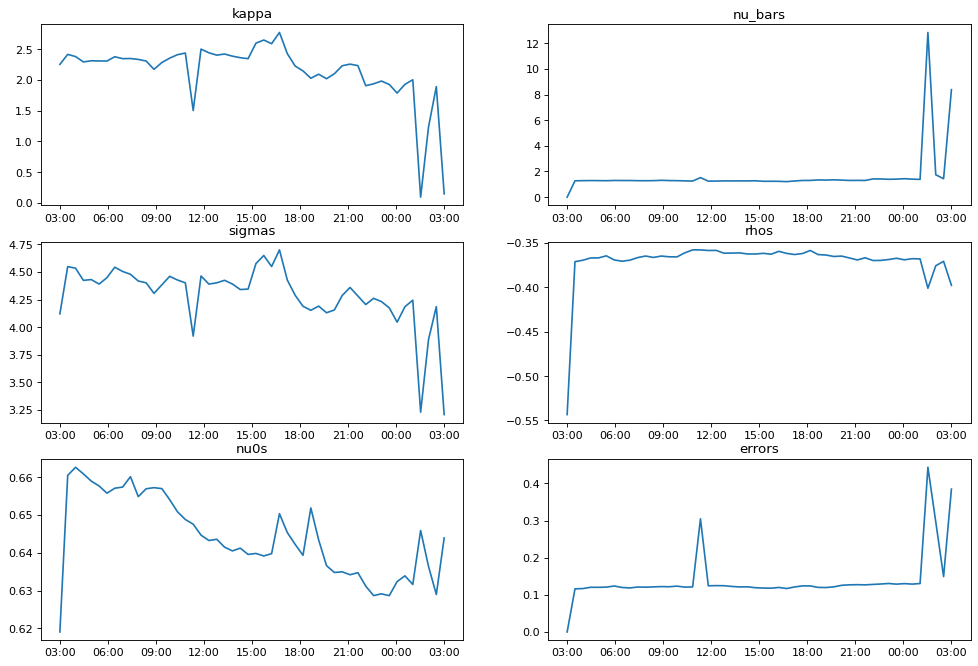

In [244]:
figure(figsize=(15, 10), dpi=80)
ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)
ax5 = plt.subplot(325)
ax6 = plt.subplot(326)


ax1.plot(timestamps_hm, kappas)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.set_title("kappa")

ax2.plot(timestamps_hm, nu_bars)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.set_title("nu_bars")

ax3.plot(timestamps_hm, sigmas)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax3.set_title("sigmas")

ax4.plot(timestamps_hm, rhos)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax4.set_title("rhos")


ax5.plot(timestamps_hm, nu0s)
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax5.set_title("nu0s")

ax6.plot(timestamps_hm, errors)
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax6.set_title("errors")

plt.show()